# Interspeech 2026

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers.utils.notebook import NotebookProgressBar

import torchaudio.transforms as T

from voicestudio.utils.audio_utils import show_waveform

### Check GPU Availability

In [3]:
!nvidia-smi

Fri Feb 20 03:57:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX PRO 6000 Blac...    Off |   00000000:01:00.0 Off |                    0 |
| 30%   27C    P8             11W /  300W |      18MiB /  97887MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Set CUDA Device Number
DEVICE_NUM = 0

if torch.cuda.is_available():
    device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

device_map = f"cuda:{DEVICE_NUM}" if DEVICE_NUM >= 0 else "cpu"
print(f"INFO: Using device - {device}")

INFO: Using device - cuda:0


## Datasets

In [5]:
from spk_incon.datasets import LIBRITTS_P_Custom
from spk_incon.datasets.libritts_p3 import download_libritts_p_metadata

In [6]:
DATA_ROOT = "./data"
Z_THRESHOLD = 2.5
URL = "https://dolab-data.duckdns.org/api/public/dl/-qA96ilN"

In [7]:
if not os.path.isfile(os.path.join(DATA_ROOT, "train-clean-100.tar.gz")):
    !wget -O "./data/train-clean-100.tar.gz" {URL}

In [8]:
download_libritts_p_metadata(root=DATA_ROOT, annotator="df1")
curated_dataset = LIBRITTS_P_Custom(root=DATA_ROOT, download=True, max_z_score=3.5)#float("inf"))

[INFO] Loading cached dataset from data/.cache/libritts_p_train-clean-100/dataset...
[INFO] Filtering outliers (max_z_score=3.5)...
[INFO] Filtered: 33187 -> 31504 samples.


## Models

In [9]:
from transformers import AutoTokenizer, AutoProcessor

from voicestudio.models.parler_tts import ParlerTTSForConditionalGeneration
from voicestudio.models.qwen3_tts import Qwen3TTSForConditionalGeneration

In [10]:
from spk_incon.models.selective_tuner import SelectiveTunerForConditionalGeneration, SelectiveTunerConfig
from spk_incon.components.style_anchor import DirectStyleAnchorEmbedding, EncoderStyleAnchorEmbedding, MixedStyleAnchorEmbedding

### Model Selection

In [11]:
# Model select
#model_id = "parler-tts/parler-tts-mini-v1"
#model_id = "parler-tts/parler-tts-large-v1"
#model_id = "parler-tts/parler-tts-mini-v1.1"

#model_id = "Qwen/Qwen3-TTS-12Hz-1.7B-Base"
model_id = "Qwen/Qwen3-TTS-12Hz-1.7B-VoiceDesign"

In [12]:
# Model loading
if "parler" in model_id.lower():
    model = ParlerTTSForConditionalGeneration.from_pretrained(
        model_id, device_map=device_map
    )
    model_dtype = model.config.dtype = model.dtype
    processor = AutoProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
elif "qwen" in model_id.lower():
    model = Qwen3TTSForConditionalGeneration.from_pretrained(
        model_id, device_map=device_map, dtype=torch.bfloat16, attn_implementation="eager",
    )
    model_dtype = model.config.dtype = model.dtype
    processor = AutoProcessor.from_pretrained(model_id, device_map=device_map)
    tokenizer = processor.tokenizer
else:
    pass

model

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen3TTSForConditionalGeneration(
  (talker): Qwen3TTSTalkerForConditionalGeneration(
    (model): Qwen3TTSTalkerModel(
      (layers): ModuleList(
        (0-27): 28 x Qwen3TTSTalkerDecoderLayer(
          (self_attn): Qwen3TTSTalkerAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
            (k_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
          )
          (mlp): Qwen3TTSTalkerTextMLP(
            (gate_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (up_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (down_proj): Linear(in_features=6144, out_features=2048, bias=False)
            (act_fn): SiLUActivation

### Embedding-tuner Selection

In [13]:
# Mode settings
ENABLE_BOS_TOKEN_TUNING = False  # this wiil trigger use_mixed_anchor
ADD_CONSISTENCY_TOKEN = True
ADD_STYLE_TOKEN = False

In [14]:
# Token definitions
BOS_TOKEN = "</s>"
BOS_TOKEN_ID = 1
STYLE_TOKEN = "<style>"
STYLE_TOKEN_ID = len(tokenizer)
CONSISTENCY_TOKEN = "<consistency>"
CONSISTENCY_TOKEN_ID = len(tokenizer) + 1

In [15]:
anchor_token = []
anchor_token_id = []
use_direct_anchor = False
use_mixed_anchor = False
result_id = ""

if ADD_CONSISTENCY_TOKEN:
    anchor_token.append(CONSISTENCY_TOKEN)
    anchor_token_id.append(CONSISTENCY_TOKEN_ID)
    result_id = "consistency"
if ADD_STYLE_TOKEN:
    anchor_token.append(STYLE_TOKEN)
    anchor_token_id.append(STYLE_TOKEN_ID)
    if result_id:
        result_id = "all"
    else:
        result_id = "style"

anchor_token = tuple(anchor_token)
anchor_token_id = tuple(anchor_token_id)

if ENABLE_BOS_TOKEN_TUNING:
    use_mixed_anchor = True
    anchor_token = ((BOS_TOKEN, ), anchor_token)
    anchor_token_id = ((BOS_TOKEN_ID, ), anchor_token_id)
    result_id += "_bos"

In [16]:
# Backup original config
from copy import deepcopy
original_config = deepcopy(model.config)
print("Original Model Config:")
for key, value in original_config.to_dict().items():
    print(f"{key}: {value}")

Original Model Config:
return_dict: True
output_hidden_states: False
torchscript: False
dtype: bfloat16
pruned_heads: {}
tie_word_embeddings: True
chunk_size_feed_forward: 0
is_encoder_decoder: False
is_decoder: False
cross_attention_hidden_size: None
add_cross_attention: False
tie_encoder_decoder: False
architectures: ['Qwen3TTSForConditionalGeneration']
finetuning_task: None
id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
label2id: {'LABEL_0': 0, 'LABEL_1': 1}
task_specific_params: None
problem_type: None
tokenizer_class: None
prefix: None
bos_token_id: None
pad_token_id: None
eos_token_id: None
sep_token_id: None
decoder_start_token_id: None
max_length: 20
min_length: 0
do_sample: False
early_stopping: False
num_beams: 1
temperature: 1.0
top_k: 50
top_p: 1.0
typical_p: 1.0
repetition_penalty: 1.0
length_penalty: 1.0
no_repeat_ngram_size: 0
encoder_no_repeat_ngram_size: 0
bad_words_ids: None
num_return_sequences: 1
output_scores: False
return_dict_in_generate: False
forced_bos_token_id: None


In [17]:
print(f"BOS token: {tokenizer.bos_token}, ID: {tokenizer.bos_token_id}")
print(f"EOS token: {tokenizer.eos_token}, ID: {tokenizer.eos_token_id}")
print(f"PAD token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}")

BOS token: None, ID: None
EOS token: <|im_end|>, ID: 151645
PAD token: <|endoftext|>, ID: 151643


In [18]:
im_start_id = tokenizer.convert_tokens_to_ids("<|im_start|>")
print(im_start_id)

151644


In [19]:
# Create new config
config = SelectiveTunerConfig.from_pretrained(
    model.config,
    anchor_token=anchor_token, anchor_token_id=anchor_token_id,
    use_direct_anchor=use_direct_anchor, use_mixed_anchor=use_mixed_anchor, tie_embeddings=True
)

In [20]:
trainable_indices = torch.tensor(anchor_token_id)

def make_mask_hook(indices, vocab_size):
    mask = torch.zeros(vocab_size)
    mask[indices] = 1.0
    
    def hook(grad):
        m = mask.to(dtype=grad.dtype, device=grad.device)
        return grad * m.unsqueeze(1)
    return hook

In [21]:
# Config setup
if "parler" in model_id.lower():
    setattr(config, 'hidden_size', config.decoder.hidden_size)  # parler-tts doesn't have decoder hidden_size conf
elif "qwen" in model_id.lower():
    setattr(config, 'vocab_size', config.talker_config.text_vocab_size)
    setattr(config, 'hidden_size', config.talker_config.hidden_size)
    model.talker.get_text_embeddings().weight.register_hook(
        make_mask_hook(trainable_indices, config.talker_config.text_vocab_size)
    )
else:
    pass

config.hidden_size, config.vocab_size

(2048, 151936)

In [22]:
# Apply selective embedding tuner
#SelectiveTunerForConditionalGeneration._replace_embeddings_with_anchors(model, config)
#model.to(device=device, dtype=model_dtype)
model.config = config  # override config
model.eval()

Qwen3TTSForConditionalGeneration(
  (talker): Qwen3TTSTalkerForConditionalGeneration(
    (model): Qwen3TTSTalkerModel(
      (layers): ModuleList(
        (0-27): 28 x Qwen3TTSTalkerDecoderLayer(
          (self_attn): Qwen3TTSTalkerAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
            (k_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
          )
          (mlp): Qwen3TTSTalkerTextMLP(
            (gate_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (up_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (down_proj): Linear(in_features=6144, out_features=2048, bias=False)
            (act_fn): SiLUActivation

In [23]:
# Extend vocabulary
SelectiveTunerForConditionalGeneration.extend_vocabulary(model, processor.tokenizer)

In [24]:
# roll-back to original config for saving
model.config = original_config

Setting `pad_token_id` to `eos_token_id`:2150 for open-end generation.


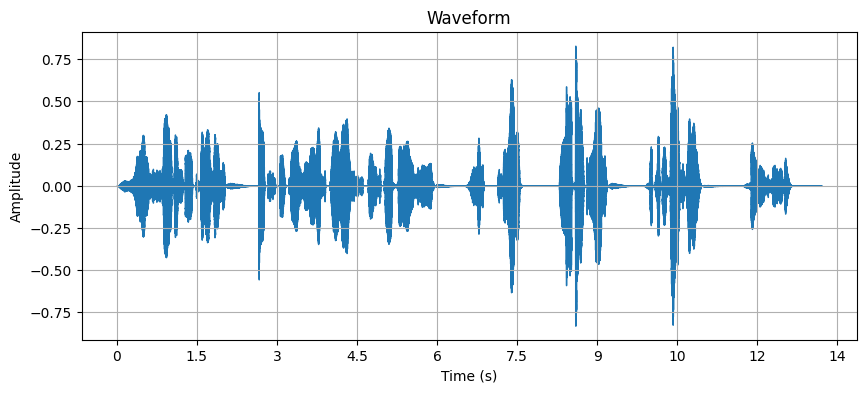

In [25]:
# Check model still works after modification
if "parler" in model_id.lower():
    prompt = "Hey, how are you doing today?"
    #description = "Jon's voice is monotone yet slightly fast in delivery, with a very close recording that almost has no background noise."
    description = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."
    input_ids, prompt_input_ids = (tokenizer(d, return_tensors="pt").input_ids.to(device) for d in [description, prompt])

    outputs = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
    audio_values, sr = outputs.cpu().squeeze(), model.config.sampling_rate
elif "qwen" in model_id.lower():
    inputs = processor.encode_voice_design(
        text="I am solving the equation: x = [-b ± √(b²-4ac)] / 2a? Nobody can — it's a disaster (◍•͈⌔•͈◍), very sad!",
        instruct="Happy man describes the equation in a cheerful tone, with a hint of humor. He emphasizes the complexity of the equation and expresses his feelings about it in a lighthearted way.",
    )
    outputs = model.generate(**inputs)

    audio_values, sr = processor.decode(outputs)
    audio_values = torch.from_numpy(audio_values[0])
else:
    pass

show_waveform(None, waveform=audio_values, sr=sr)

## DataLoader

In [26]:
BATCH_SIZE = 16

In [27]:
sample_data = curated_dataset[50]
sample_data_organized = dict(
    instruction=sample_data['combined_prompt'],
    text=sample_data['normalized_text'],
    output=sample_data['waveform'],
    sample_rate=sample_data['sample_rate']
)
sample_data_organized

{'instruction': "ask a woman with normal pitch to speak with low volume and slow speaking speed The speaker's identity can be described as intellectual, slightly young, sharp, feminine, tensed, calm, lively, powerful, fluent, clear.",
 'text': '"Well now, I dunno," said matthew.',
 'output': tensor([[0.0031, 0.0028, 0.0033,  ..., 0.0027, 0.0026, 0.0024]]),
 'sample_rate': 24000}

In [28]:
def collate_fn(batch_list):
    instructions = [item['combined_prompt'] for item in batch_list]
    texts = [
        (CONSISTENCY_TOKEN + item['normalized_text']) if item['distance_z_score'] < Z_THRESHOLD 
        else item['normalized_text'] 
        for item in batch_list
    ]
    outputs = [item['waveform'].cpu().numpy() for item in batch_list]
    sample_rates = [item['sample_rate'] for item in batch_list]

    # ── 1. audio → codec codes ──────────────────────────────────────────
    prompt_codes = []  # list of (T, 16)
    for wav, sr in zip(outputs, sample_rates):
        audio_list = processor._normalize_audio_inputs([wav], sr)
        feature_inputs = processor.feature_extractor(
            raw_audio=audio_list,
            sampling_rate=int(processor.feature_extractor.sampling_rate),
            return_tensors="pt"
        ).to(device).to(processor.audio_tokenizer.dtype)

        with torch.inference_mode():
            audio_outputs = processor.audio_tokenizer.encode(
                feature_inputs["input_values"].squeeze(1),
                feature_inputs["padding_mask"].squeeze(1),
                return_dict=True,
            )
        prompt_codes.append(audio_outputs.audio_codes[0])  # (C, 16)

    # ── 2. text tokenize ─────────────────────────────────────────────────
    text_id_list = []
    instruct_id_list = []
    for text, instruct in zip(texts, instructions):
        t_ids = tokenizer(
            f"<|im_start|>assistant\n{text}<|im_end|>\n<|im_start|>assistant\n",
            return_tensors="pt"
        ).input_ids  # (1, L)
        i_ids = tokenizer(
            f"<|im_start|>user\n{instruct}<|im_end|>\n",
            return_tensors="pt"
        ).input_ids  # (1, Li)
        text_id_list.append(t_ids)
        instruct_id_list.append(i_ids)

    # ── 3. embedding 계산 및 context 구성 ───────────────────────────────
    talker = model.talker
    cfg = model.config

    def text_embed(ids):
        return talker.text_projection(talker.get_text_embeddings()(ids.to(device)))

    def codec_embed_0(ids):
        return talker.get_input_embeddings()(ids.to(device))

    sample_embeds = []
    codec_0_labels_list = []
    codec_ids_list = []
    codec_mask_list = []

    for t_ids, ins_ids, codes in zip(text_id_list, instruct_id_list, prompt_codes):
        # t_ids: (1, L),  codes: (C, 16)
        C = codes.shape[0]
        text_body_len = t_ids.shape[1] - 3 - 5  # role(3) + trailing(5) 제외

        tts_bos_embed, tts_eos_embed, tts_pad_embed = text_embed(
            torch.tensor([[cfg.tts_bos_token_id, cfg.tts_eos_token_id, cfg.tts_pad_token_id]])
        ).chunk(3, dim=1)  # 각 (1, 1, D)

        # ① instruct: text channel만
        e_instruct = text_embed(ins_ids)  # (1, Li, D)

        # ② role: "<|im_start|>assistant\n" (3 tokens)
        e_role = text_embed(t_ids[:, :3])  # (1, 3, D)

        # ③ codec prefix(4칸): text=[tts_pad*3, tts_bos], codec=[nothink, think_bos, think_eos, codec_pad]
        e_codec_prefix = codec_embed_0(
            torch.tensor([[
                cfg.talker_config.codec_nothink_id,
                cfg.talker_config.codec_think_bos_id,
                cfg.talker_config.codec_think_eos_id,
                cfg.talker_config.codec_pad_id,
            ]])
        )  # (1, 4, D)
        e_text_prefix = torch.cat([
            tts_pad_embed.expand(-1, 3, -1),
            tts_bos_embed,
        ], dim=1)  # (1, 4, D)
        e_prefix = e_text_prefix + e_codec_prefix  # (1, 4, D)

        # ④ text body + tts_eos / codec=codec_pad
        e_text_body = torch.cat([
            text_embed(t_ids[:, 3:-5]),  # (1, text_body_len, D)
            tts_eos_embed,               # (1, 1, D)
        ], dim=1)  # (1, text_body_len+1, D)
        e_codec_pad_body = codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_pad_id] * (text_body_len + 1)])
        )  # (1, text_body_len+1, D)
        e_body = e_text_body + e_codec_pad_body  # (1, text_body_len+1, D)

        # ⑤ codec_bos: text=tts_pad, codec=codec_bos
        e_codec_bos = tts_pad_embed + codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_bos_id]])
        )  # (1, 1, D)

        # ⑥ audio codec tokens: text=tts_pad, codec=sum of all quantizers
        e_audio = tts_pad_embed.expand(-1, C, -1).clone()
        e_audio = e_audio + codec_embed_0(codes[:, 0].unsqueeze(0))  # codebook 0
        for q in range(1, 16):
            e_audio = e_audio + talker.code_predictor.get_input_embeddings()[q-1](
                codes[:, q].unsqueeze(0)
            )  # (1, C, D)

        # ⑦ codec EOS: text=tts_pad, codec=codec_eos
        e_codec_eos = tts_pad_embed + codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_eos_token_id]])
        )  # (1, 1, D)

        # 전체 concat
        full_embed = torch.cat([
            e_instruct,   # (1, Li, D)
            e_role,       # (1, 3, D)
            e_prefix,     # (1, 4, D)
            e_body,       # (1, text_body_len+1, D)
            e_codec_bos,  # (1, 1, D)
            e_audio,      # (1, C, D)
            e_codec_eos,  # (1, 1, D)
        ], dim=1)  # (1, T, D)
        sample_embeds.append(full_embed)

        # labels: codec 구간 + EOS만 살리고 나머지 -100
        total_len = full_embed.shape[1]
        prefix_len = ins_ids.shape[1] + 3 + 4 + (text_body_len + 1) + 1  # codec token 시작 위치
        labels = torch.full((total_len,), -100, dtype=torch.long)
        labels[prefix_len: prefix_len + C] = codes[:, 0]
        labels[prefix_len + C] = cfg.talker_config.codec_eos_token_id
        codec_0_labels_list.append(labels)

        # codec_ids: (total_len, 16)
        cids = torch.zeros(total_len, 16, dtype=torch.long)
        cids[prefix_len: prefix_len + C] = codes
        codec_ids_list.append(cids)

        # codec_mask: audio codec 구간만 True (EOS 제외 — sft_12hz.py 동일)
        cmask = torch.zeros(total_len, dtype=torch.bool)
        cmask[prefix_len: prefix_len + C] = True
        codec_mask_list.append(cmask)

    # ── 4. left-padding & batch ──────────────────────────────────────────
    B = len(sample_embeds)
    seqs = [e.squeeze(0) for e in sample_embeds]
    original_lengths = torch.tensor([s.shape[0] for s in seqs])
    max_len = original_lengths.max().item()

    # inputs_embeds: left pad
    seqs_rev = [s.flip(0) for s in seqs]
    padded_rev = torch.nn.utils.rnn.pad_sequence(seqs_rev, batch_first=True, padding_value=0.0)
    inputs_embeds = padded_rev.flip(1).to(device)  # (B, max_len, D)

    # attention_mask
    num_pads = max_len - original_lengths
    indices = torch.arange(max_len).expand(B, -1)
    attention_mask = (indices >= num_pads.unsqueeze(1)).long().to(device)

    # labels, codec_ids, codec_mask: left pad
    codec_0_labels = torch.full((B, max_len), -100, dtype=torch.long)
    codec_ids      = torch.zeros(B, max_len, 16, dtype=torch.long)
    codec_mask     = torch.zeros(B, max_len, dtype=torch.bool)

    for i, (lab, cids, cmask, l) in enumerate(zip(codec_0_labels_list, codec_ids_list, codec_mask_list, original_lengths)):
        codec_0_labels[i, max_len - l:] = lab
        codec_ids[i, max_len - l:]      = cids
        codec_mask[i, max_len - l:]     = cmask

    codec_0_labels = codec_0_labels.to(device)
    codec_ids      = codec_ids.to(device)
    codec_mask     = codec_mask.to(device)

    return dict(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        codec_0_labels=codec_0_labels,
        codec_ids=codec_ids,
        codec_mask=codec_mask,
    )

In [29]:
data_loader = DataLoader(curated_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=collate_fn)
data_loader = DataLoader(curated_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)

## Training

### Set trainable params

In [30]:
for param in model.parameters():
    param.requires_grad = False

for module in model.modules():
    if isinstance(module, (DirectStyleAnchorEmbedding, EncoderStyleAnchorEmbedding, MixedStyleAnchorEmbedding)):
        print(f"INFO: Found a target embedding instance: {type(module).__name__}")
        for param in module.parameters():
            param.requires_grad = True

    if hasattr(module, 'q_proj') and hasattr(module, 'k_proj'):
        print(f"INFO: Unfreezing Q and K projections in: {type(module).__name__}")
        module.q_proj.weight.requires_grad = True
        module.k_proj.weight.requires_grad = True
        if module.q_proj.bias is not None:
            module.q_proj.bias.requires_grad = True
        if module.k_proj.bias is not None:
            module.k_proj.bias.requires_grad = True

INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K 

In [31]:
if "qwen" in model_id.lower():
    print("INFO: Unfreezing token embeddings in talker...")
    model.talker.get_text_embeddings().weight.requires_grad = True

INFO: Unfreezing token embeddings in talker...


### Fine-tuning

In [32]:
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./results/" + model_id + "/" + result_id

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [33]:
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE, weight_decay=0.01)
epoch_steps = int(len(curated_dataset) / BATCH_SIZE + 0.99)
total_steps = epoch_steps * NUM_EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=LEARNING_RATE/100)

print(f"INFO: dataset len={len(curated_dataset)}, total_steps={total_steps}")

INFO: dataset len=31504, total_steps=19690


In [34]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

# 파라미터 그룹 분리
embed_params = [model.talker.get_text_embeddings().weight]
qk_params = [
    p for name, p in model.named_parameters()
    if p.requires_grad and 'embed' not in name
]

optimizer = AdamW([
    {"params": embed_params, "lr": 1e-3},
    {"params": qk_params,    "lr": 2e-5},
], weight_decay=0.01)

# Scheduler
warmup_steps = 100
cosine_steps = total_steps - warmup_steps

warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
cosine = CosineAnnealingLR(optimizer, T_max=cosine_steps, eta_min=2e-6)  # embed eta_min도 2e-4로 따로 쓰고 싶으면 param group별 scheduler 분리 필요
scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps])

In [35]:
START_EPOCH = 62

In [36]:
def remove_dtype(config):
    config.__dict__.pop('dtype', None)
    for v in config.__dict__.values():
        from transformers import PretrainedConfig
        if isinstance(v, PretrainedConfig):
            remove_dtype(v)

remove_dtype(model.config)

In [37]:
from matplotlib import pyplot as plt

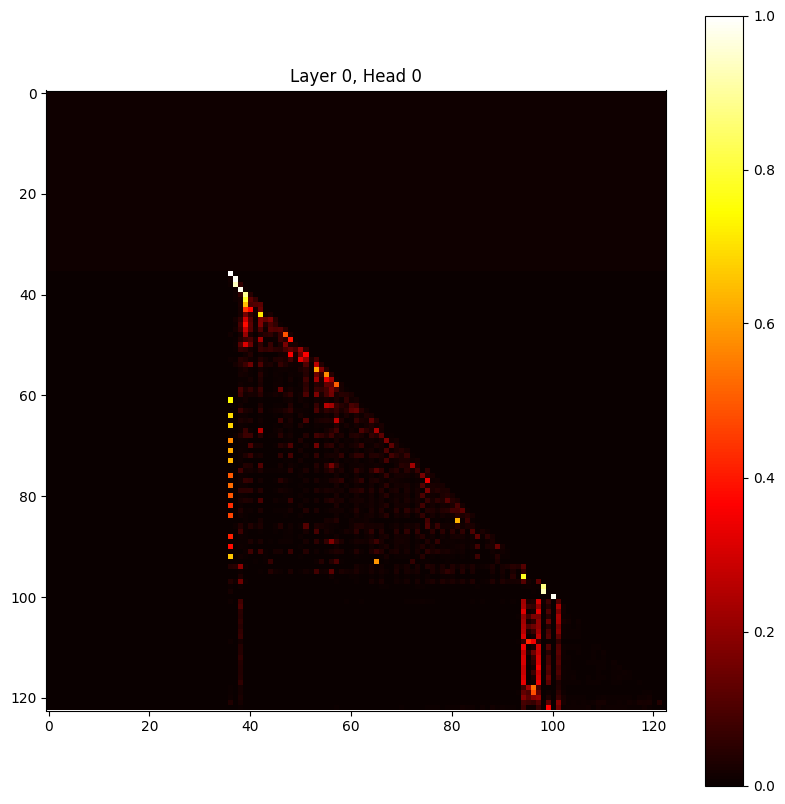

In [38]:
# 데이터로더에서 배치 하나 가져오기
sample_batch = next(iter(data_loader))

with torch.no_grad():
    outputs = model.talker(
        inputs_embeds=sample_batch['inputs_embeds'][:1],
        attention_mask=sample_batch['attention_mask'][:1],
        output_attentions=True,
        output_hidden_states=True,
    )

# 레이어별 attention map 시각화
attentions = outputs.attentions  # (num_layers, batch, heads, seq, seq)

layer, head = 0, 0
attn = attentions[layer][0, head].cpu().float()

plt.figure(figsize=(10, 10))
plt.imshow(attn, cmap='hot')
plt.colorbar()
plt.title(f"Layer {layer}, Head {head}")
plt.show()

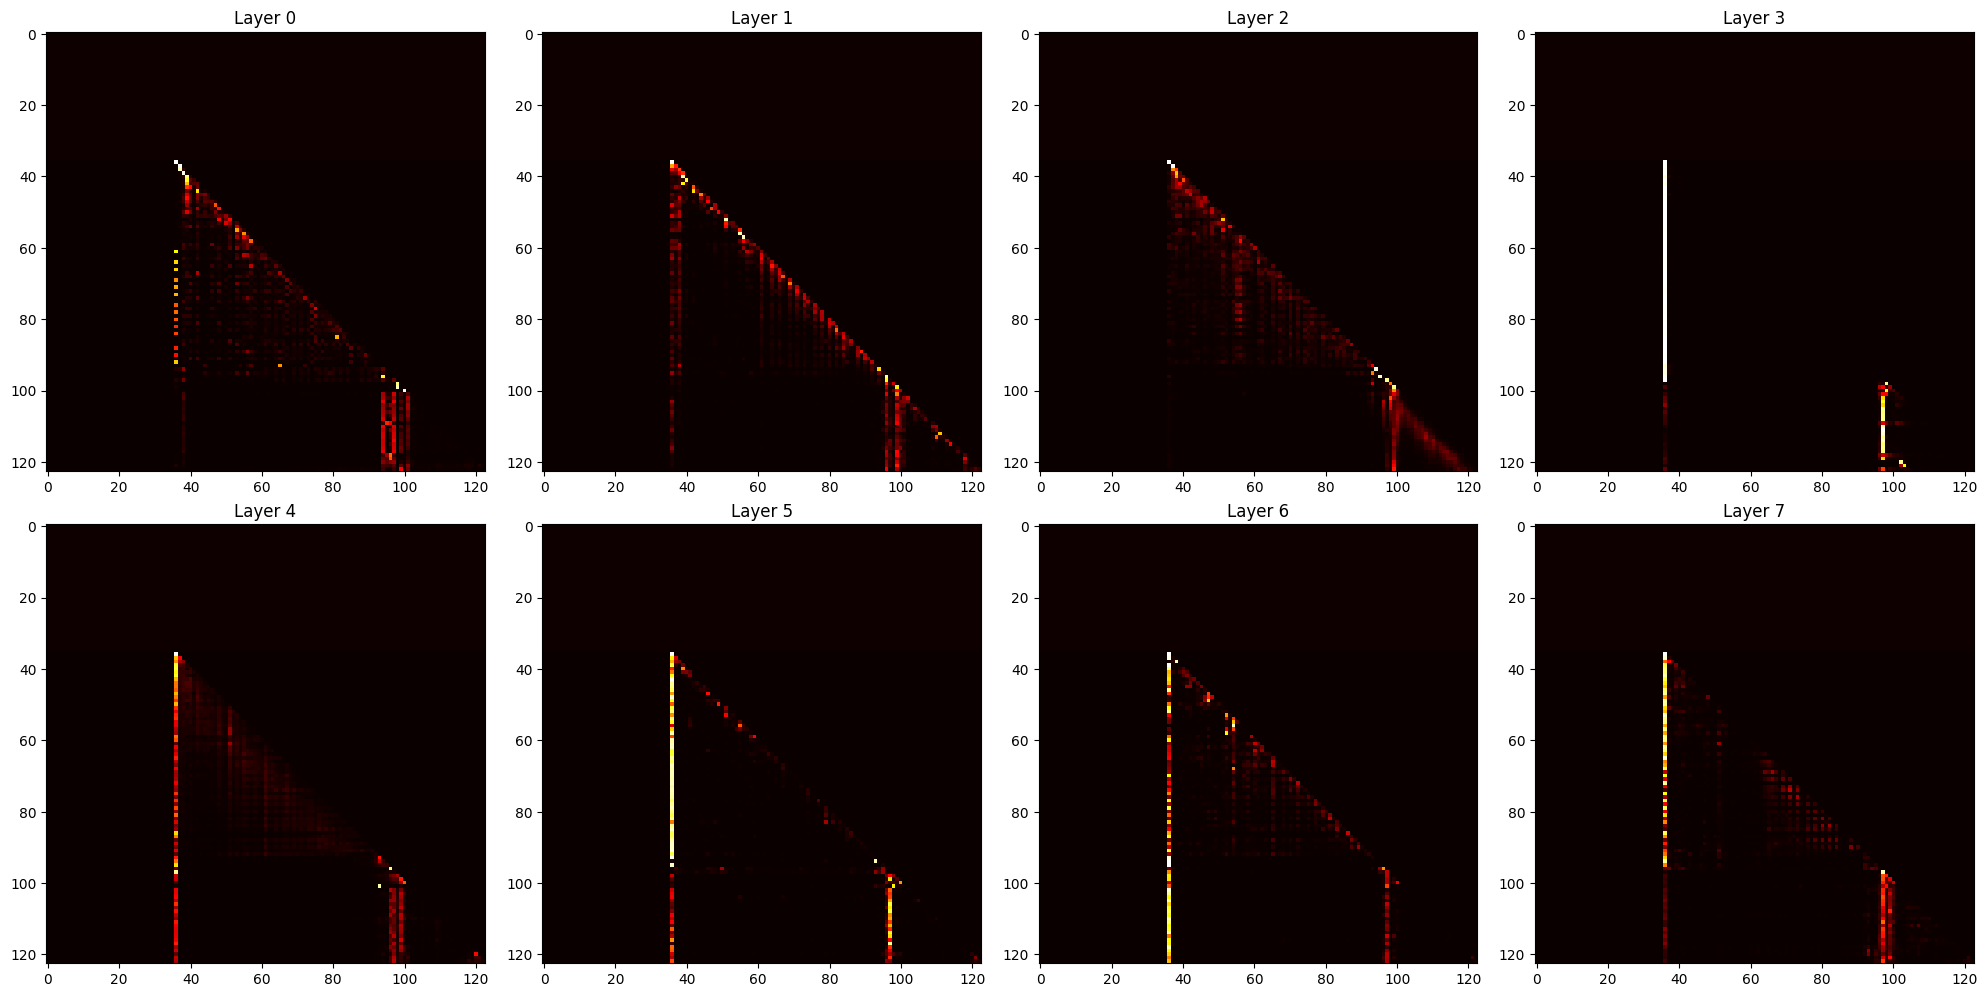

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    attn = attentions[i][0, 0].cpu().float()
    ax.imshow(attn, cmap='hot')
    ax.set_title(f"Layer {i}")
plt.tight_layout()
plt.show()

In [41]:
pad_len = (sample_batch['attention_mask'][0] == 0).sum().item()
print(f"padding length: {pad_len}")

# 35~40번째 토큰이 뭔지
# collate_fn 구조상 instruct 끝부분일 가능성이 높음

padding length: 36


In [43]:
model.eval()
sample_batch = next(iter(data_loader))
model.train()

# padding 길이 확인
pad_len = (sample_batch['attention_mask'][0] == 0).sum().item()
print(f"padding length: {pad_len}")

with torch.no_grad():
    outputs = model.talker(
        inputs_embeds=sample_batch['inputs_embeds'][:1],
        attention_mask=sample_batch['attention_mask'][:1],
        output_attentions=True,
        output_hidden_states=True,
    )

attentions = outputs.attentions

# sink 위치 찾기 (column sum이 높은 위치)
layer = 3  # sink가 가장 뚜렷했던 레이어
attn = attentions[layer][0].mean(0).cpu().float()  # head 평균
col_sum = attn.sum(0)
sink_pos = col_sum.argmax().item()
print(f"sink position (absolute): {sink_pos}")
print(f"sink position (relative to content, pad removed): {sink_pos - pad_len}")

# 해당 위치의 임베딩을 토큰으로 역추적
# inputs_embeds에서 해당 위치의 벡터를 가져와서 가장 가까운 토큰 찾기
target_embed = sample_batch['inputs_embeds'][0, sink_pos]  # (D,)

# text embedding table과 cosine similarity 비교
embed_table = model.talker.get_text_embeddings().weight  # (vocab_size, D)
with torch.no_grad():
    # text projection 통과 전 임베딩이라 projection 역산은 못하니까
    # codec embedding table도 같이 확인
    cos_sim_text = F.cosine_similarity(
        target_embed.unsqueeze(0).to(embed_table.device),
        embed_table.float(),
        dim=1
    )
    top_text = cos_sim_text.topk(5)
    print("\n[Text embedding 기준 top5 유사 토큰]")
    for score, idx in zip(top_text.values, top_text.indices):
        print(f"  token_id={idx.item()}, token='{tokenizer.convert_ids_to_tokens([idx.item()])}', cos_sim={score.item():.4f}")

# collate_fn 구조상 위치 추정도 같이 출력
print(f"\n[구조 추정]")
print(f"전체 시퀀스 길이: {sample_batch['inputs_embeds'].shape[1]}")
print(f"content 시작: {pad_len}")
print(f"sink 위치: {sink_pos} → content 내 {sink_pos - pad_len}번째 토큰")

padding length: 60
sink position (absolute): 60
sink position (relative to content, pad removed): 0

[Text embedding 기준 top5 유사 토큰]
  token_id=57886, token='['.chrome']', cos_sim=0.0990
  token_id=33017, token='['smith']', cos_sim=0.0931
  token_id=136844, token='['ĠÑģÐ¾Ð²Ñģ']', cos_sim=0.0890
  token_id=7166, token='['enty']', cos_sim=0.0848
  token_id=98735, token='['.isFile']', cos_sim=0.0837

[구조 추정]
전체 시퀀스 길이: 149
content 시작: 60
sink 위치: 60 → content 내 0번째 토큰


In [44]:
# <|im_start|> 토큰 ID 확인
im_start_id = tokenizer.convert_tokens_to_ids("<|im_start|>")
print(f"<|im_start|> token_id: {im_start_id}")

# collate_fn 구조상 <|im_start|> 위치 추정
# instruct 토큰 길이 먼저 확인
sample_item = curated_dataset[50]
instruct_text = f"<|im_start|>user\n{sample_item['combined_prompt']}<|im_end|>\n"
text_text = f"<|im_start|>assistant\n{sample_item['normalized_text']}<|im_end|>\n<|im_start|>assistant\n"

instruct_ids = tokenizer(instruct_text, return_tensors="pt").input_ids
text_ids = tokenizer(text_text, return_tensors="pt").input_ids

print(f"instruct 길이: {instruct_ids.shape[1]}")
print(f"text 길이: {text_ids.shape[1]}")

# <|im_start|> 위치 찾기
im_start_positions_in_instruct = (instruct_ids[0] == im_start_id).nonzero().squeeze().tolist()
im_start_positions_in_text = (text_ids[0] == im_start_id).nonzero().squeeze().tolist()
print(f"instruct 내 <|im_start|> 위치: {im_start_positions_in_instruct}")
print(f"text 내 <|im_start|> 위치: {im_start_positions_in_text}")

# content 시작(pad_len)을 기준으로 절대 위치 계산
# instruct가 먼저 오고 그 다음 text 구조
abs_positions = [
    pad_len + pos for pos in ([im_start_positions_in_instruct] if isinstance(im_start_positions_in_instruct, int) else im_start_positions_in_instruct)
] + [
    pad_len + instruct_ids.shape[1] + pos for pos in ([im_start_positions_in_text] if isinstance(im_start_positions_in_text, int) else im_start_positions_in_text)
]
print(f"\n<|im_start|> 절대 위치들: {abs_positions}")

# 각 레이어에서 해당 위치들의 column sum 비교
print("\n[레이어별 <|im_start|> 위치 column sum 비교]")
print(f"{'Layer':<8}", end="")
for pos in abs_positions:
    print(f"pos={pos:<8}", end="")
print()

for layer_idx in range(len(attentions)):
    attn = attentions[layer_idx][0].mean(0).cpu().float()  # head 평균, (seq, seq)
    col_sums = [attn[:, pos].sum().item() if pos < attn.shape[1] else 0.0 for pos in abs_positions]
    print(f"{layer_idx:<8}", end="")
    for s in col_sums:
        print(f"{s:<12.4f}", end="")
    print()

<|im_start|> token_id: 151644
instruct 길이: 50
text 길이: 19
instruct 내 <|im_start|> 위치: 0
text 내 <|im_start|> 위치: [0, 16]

<|im_start|> 절대 위치들: [60, 110, 126]

[레이어별 <|im_start|> 위치 column sum 비교]
Layer   pos=60      pos=110     pos=126     
0       3.0464      0.9732      1.0691      
1       5.2414      0.7635      0.8647      
2       3.4272      0.7808      0.8288      
3       50.3823     0.5579      0.7827      
4       43.5962     0.6226      0.5803      
5       47.3145     0.6881      0.6180      
6       45.5732     0.6937      0.4801      
7       37.1782     0.6969      0.4849      
8       55.5312     0.5080      0.4513      
9       44.6646     0.6136      0.5062      
10      47.8706     0.5902      0.4926      
11      40.5659     0.6962      0.5879      
12      51.1089     0.5381      0.6187      
13      53.7427     0.4983      0.5912      
14      56.1196     0.5413      0.6732      
15      46.9448     0.6487      0.6489      
16      58.8530     0.4863      0.5893  

In [40]:
model.train()

total_bar = NotebookProgressBar(NUM_EPOCHS, prefix="Running Epochs")
for epoch in range(START_EPOCH-1, NUM_EPOCHS+60):
    total_bar.update(epoch+1)
    train_loss, train_mfcc = [], []

    train_bar = NotebookProgressBar(epoch_steps, prefix=f"Training {epoch+1}")
    for i, inputs in enumerate(data_loader):
        optimizer.zero_grad()

        try:
            if "qwen" in model_id.lower():
                outputs = model.talker(
                    inputs_embeds=inputs['inputs_embeds'][:, :-1, :],
                    attention_mask=inputs['attention_mask'][:, :-1],
                    labels=inputs['codec_0_labels'][:, 1:],
                    output_hidden_states=True
                )

                hidden_states = outputs.hidden_states[0][-1]

                # codec_mask도 :-1 로 잘라서 inputs_embeds와 길이 맞추기
                codec_mask_shifted = inputs['codec_mask'][:, :-1]
                talker_hidden_states = hidden_states[codec_mask_shifted]
                talker_codec_ids = inputs['codec_ids'][:, :-1][codec_mask_shifted]

                sub_talker_logits, sub_talker_loss = model.talker.forward_sub_talker_finetune(
                    talker_codec_ids, talker_hidden_states
                )
                outputs.loss = outputs.loss + 0.3 * sub_talker_loss
            else:
                outputs = model(**inputs)
        except (torch.cuda.OutOfMemoryError, RuntimeError):
            import gc
            gc.collect()
            torch.cuda.empty_cache()
            continue

        losses = outputs.loss

        losses.backward()
        optimizer.step()
        scheduler.step()

        train_loss.append(losses.item())

        if i+1 != train_bar.total: train_bar.update(i+1, comment=f"Loss={losses.item():.5f}, LR={optimizer.param_groups[0]['lr']:.1e}")

    model.save_pretrained(OUTPUT_DIR+f"_epoch{epoch+1}")
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    train_bar.update(train_bar.total, comment=f"Loss={sum(train_loss)/len(train_loss):.5f}, LR={optimizer.param_groups[0]['lr']:.1e}")

KeyboardInterrupt: 

In [ ]:
model.save_pretrained(OUTPUT_DIR+"_last")

## Testing

In [ ]:
from spk_incon.metrics.presets import DatasetType, GenerationMethod, SynthesisConfig, ModelType
from spk_incon.metrics.strategies import create_strategy
from spk_incon.datasets import DatasetType, create_dataset

from spk_incon.utils.evaluate import EvaluationPipeline

In [ ]:
test_config = SynthesisConfig()
test_dataset_type = DatasetType.LIBRITTS
test_dataset_config = test_config.get_dataset_config(test_dataset_type.value)

In [ ]:
test_dataset = create_dataset(test_dataset_type, test_dataset_config, root_dir="./data")

In [ ]:
from pathlib import Path
import random

import numpy as np
import torch

import soundfile as sf


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TestModel:
    @classmethod
    def seed_everything(cls, seed: int = 42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    @classmethod
    def synthesize(
        cls,
        text: str,
        output_path: Path,
        reference_audio: Path | None = None,
        style_prompt: str | None = None,
        speaker_id: str | None = None
    ) -> bool:
        cls.seed_everything()
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # Adjust style prompt
        if ADD_CONSISTENCY_TOKEN:
            text = f"{CONSISTENCY_TOKEN}{text}"
        if ADD_STYLE_TOKEN:
            style_prompt = f"{style_prompt}{STYLE_TOKEN}"

        # Setup generation config
        generation_config = dict(
            #top_k=1,
        )

        # Input preparation
        if "parler" in model_id.lower():
            inputs = dict(
                input_ids=tokenizer(style_prompt, return_tensors="pt").input_ids.to(device),
                prompt_input_ids=tokenizer(text, return_tensors="pt").input_ids.to(device)
            )
        elif "qwen" in model_id.lower():
            inputs = processor.encode_voice_design(
                text=text, instruct=style_prompt,
            )

        # Generation
        outputs = model.generate(**inputs, **generation_config)

        # Decoding
        if "parler" in model_id.lower():
            audio_values = outputs.cpu().numpy().squeeze()
            sample_rate = config.audio_encoder.sampling_rate
        elif "qwen" in model_id.lower():
            audio_values, sample_rate = processor.decode(outputs)
            audio_values = audio_values[0]

        # Save audio
        sf.write(output_path, audio_values, sample_rate)
        try:
            return output_path.stat().st_size > 0
        except FileNotFoundError:
            return False

In [ ]:
from enum import Enum

class ModelType(Enum):
    TEST = model.__class__.__name__

In [ ]:
from pathlib import Path

test_model_type = ModelType.TEST
test_model = TestModel()

try:
    evaluator = EvaluationPipeline(base_dir=Path(OUTPUT_DIR+f"_epoch{epoch+1}"))
    test_config.generation.output_dir = Path(OUTPUT_DIR+f"_epoch{epoch+1}")
except UnboundLocalError:
    evaluator = EvaluationPipeline(base_dir=Path(OUTPUT_DIR+"_last"))
    test_config.generation.output_dir = Path(OUTPUT_DIR+"_last")

### Experiment 2

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD2, test_config, test_dataset, test_model)
exp2_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp2_result

In [ ]:
exp2_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD2]
)
evaluator.save_results_to_csv(exp2_eval_result, test_dataset_type, test_model_type)

### Experiment 1

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD1, test_config, test_dataset, test_model)
exp1_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp1_result

In [ ]:
exp1_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD1]
)
evaluator.save_results_to_csv(exp1_eval_result, test_dataset_type, test_model_type)

### Experiment 3

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD3, test_config, test_dataset, test_model)
exp3_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp3_result

In [ ]:
exp3_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD3]
)
evaluator.save_results_to_csv(exp3_eval_result, test_dataset_type, test_model_type)